# Kernighan-Lin (KL) Partitioning Algorithm

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import random
plt.rcParams["figure.figsize"] = (15,12)

class Graph:
    def __init__(self):
        self.adj_list = []
        self.nodes = []
        self.num_nodes = 0
        self.node_affiliation = {}
        self.cxy = {}
        self.node_part = {}
    
    def addNode(self, node, affiliation='p1'):
        self.num_nodes += 1
        self.nodes.append(node)
        self.node_affiliation[node] = affiliation
        self.node_part[node] = [node]
    
    def delNode(self, nodes):
        for i in nodes:
            self.nodes.remove(i)

    def addEdge(self, a, b, w):
        if(a in self.nodes and b in self.nodes):
            t, l = (min(a,b), max(a,b))
            for i in range(len(self.adj_list)):
                if(self.adj_list[i][0] == t and self.adj_list[i][1] == l):
                    self.adj_list[i][2] += w
                    self.cxy[t+l] = self.adj_list[i][2]
                    return
            self.adj_list.append([t, l, w])
            self.cxy[t+l] = w
        else:
            print("This node is not declared")
    
    def consume_edge(self, edge):
        self.node_part[edge[0]] += self.node_part[edge[1]]
        self.nodes.remove(edge[1])
        weight_dicts = {}
        delete_indices  = []
        edges = self.adj_list

        for i in range(len(self.adj_list)):
            if(edges[i][0] == edge[1] and edges[i][1] != edge[0]):
                if(edges[i][1] in weight_dicts.keys()):
                    weight_dicts[edges[i][1]] += edges[i][2]
                else:
                    weight_dicts[edges[i][1]] = edges[i][2]
                delete_indices.append(i)
            elif(edges[i][1] == edge[1] and edges[i][0] != edge[0]):
                if(edges[i][0] in weight_dicts.keys()):
                    weight_dicts[edges[i][0]] += edges[i][2]
                else:
                    weight_dicts[edges[i][0]] = edges[i][2]
                delete_indices.append(i)
            elif(edges[i][1] == edge[1] and edges[i][0] == edge[0]):
                delete_indices.append(i)
            else:
                pass
        
        delete_indices.sort(reverse=True)
        for x in delete_indices:
            del self.adj_list[x]

        for p in weight_dicts.keys():
            self.addEdge(edge[0], p, weight_dicts[p])
        
        self.num_nodes = len(self.nodes)
    
    def get_heaviest_edge(self):
        sorted_edges = sorted(self.adj_list, key= lambda x: x[2], reverse=True)
        return sorted_edges[0] 
    
    def get_cost(self):
        cost = 0
        d = self.node_affiliation
        for i in self.adj_list:
            if(d[i[0]] != d[i[1]]):
                cost += i[2]
        return cost
    
    def IE(self, node):
        #(internal, external) cost of nodes
        internal, external = 0, 0
        d = self.node_affiliation
        p = d[node]
        for i in self.adj_list:
            if(i[0] == node):
                if(d[i[1]] != p):
                    external += i[2]
                else:
                    internal += i[2]
            elif(i[1] == node):
                if(d[i[0]] != p):
                    external += i[2]
                else:
                    internal += i[2]
            else:
                pass
        return (internal, external)
        
class GraphVisualizer:
    def __init__(self):
        self.G = nx.Graph()
        self.colors = {}
    
    def reset(self):
        self.G = nx.Graph()

    def addEdges(self, graph):
        self.graph = graph
        for i in graph.nodes:
            self.G.add_node(i)
        for i in graph.adj_list:
            self.G.add_edge(i[0], i[1], weight=i[2])
        
    def visualize(self, text="Network Visualized"):
        nodes = self.graph.nodes
        p = list(set(self.graph.node_affiliation.values()))
        
        partitions = []
    
        for k in p:
            partitions.append([i for i in nodes if self.graph.node_affiliation[i] == k])
            if k not in self.colors.keys():
                self.colors[k] = '#%06X' % random.randint(0, 0xFFFFFF)
            
        
        node_colors = [self.colors[self.graph.node_affiliation[n]] for n in list(self.G.nodes)]
        pos = nx.circular_layout(self.G)
        nx.draw_networkx(self.G, pos, node_color = node_colors)
        labels = nx.get_edge_attributes(self.G, 'weight')
        nx.draw_networkx_edge_labels(self.G, pos, edge_labels=labels)
        plt.title(text)
        
        legend_handles = []
        for i in p:
            legend_handles.append(mpatches.Patch(color=self.colors[i], label=i))
        plt.legend(handles=legend_handles)
        plt.show()

In [2]:
def kerninghan_lin(graph):
    """KL algorithm for partitioning into two equal partitions"""
    nodes = graph.nodes
    increments = []
    prefix = [0]
    swaps = []
    swapped = {}
    d = graph.node_affiliation

    sort_str = lambda x: ''.join(sorted(x))
    for i in nodes:
        swapped[i] = False
    
    n = len(nodes)//2
    first = True

    I, E, D = {},{},{}
    
    for i in range(n):
        newnodes = [i for i in nodes if not swapped[i]]
        p1 = [i for i in newnodes if graph.node_affiliation[i] == 'P1']
        p2 = [i for i in newnodes if i not in p1]
        p1.sort()
        p2.sort()
        
        G = {}
        for i in newnodes:
            if first:
                I[i],E[i] = graph.IE(i)
                D[i] = E[i] - I[i]
            else:
                x = swaps[len(swaps) - 1]
                s1,s2 = sort_str(i+x[0]), sort_str(i+x[1])
                if(d[x[0]] == d[i]):
                    D[i] = D[i] + (2*graph.cxy.get(s1, 0) - 2*graph.cxy.get(s2, 0))
                else:
                    D[i] = D[i] - (2*graph.cxy.get(s1, 0) - 2*graph.cxy.get(s2, 0))
        if first:
            first = False
        
        for i in p1:
            for j in p2:
                G[i+j] = D[i] + D[j] - 2*graph.cxy.get(i+j, 0)
        
        swap = max(G, key=G.get)
        increments.append(G[swap])
        swaps.append(swap)

        swapped[swap[0]] = True
        swapped[swap[1]] = True
    
    for i in range(len(increments)):
        prefix.append(increments[i] + prefix[i])
    
    maxim_ind = np.argmax(prefix)
    return (swaps, maxim_ind-1)

In [3]:
import string

def kerninghan_lin_generic(graph):
    """Modified KL algorithm which adds difference number of dummy nodes
       in order to perform partitioning into unequal partitions"""
    nodes = graph.nodes

    n1 = len([i for i in nodes if graph.node_affiliation[i] == 'P1'])
    n2 = len(nodes) - n1

    addednodes = []

    if(n2 > n1):
        for i in range(n2-n1):
            x = [i for i in string.ascii_letters if i not in nodes][0]
            graph.addNode(x,'P1')
            addednodes.append(x)
    else:
        for i in range(n1-n2):
            x = [i for i in string.ascii_letters if i not in nodes][0]
            graph.addNode(x,'P2')
            addednodes.append(x)

    print(addednodes,"were the nodes added")
    swaps,m = kerninghan_lin(graph)
    return (swaps, m, addednodes)

In [4]:
v = GraphVisualizer()

In [5]:
import matplotlib.pyplot as plt
import networkx as nx
import random


def generate_benchmark(n=26, seed=20160):
    #n is number of nodes
    random.seed(seed)
    G = nx.erdos_renyi_graph(n, 0.5, seed=seed)

    for edge in G.edges():
        wt = random.randint(1,7)
        G[edge[0]][edge[1]]['weight'] = wt

    return G

def plot_benchmark(G, showedgewt = False): 
    pos = nx.spring_layout(G) 
    nx.draw_networkx(G, pos=pos, node_size=30, width=0.7)
    if showedgewt:
        labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)
    plt.show()

def convert_to_our_graph(G, init_partition):
    hasher = lambda x : chr(list(G.nodes())[x] + 65) 
    graph = Graph()
    
    for i in range(len(G.nodes())):
        graph.addNode(hasher(i), init_partition[i])
    
    for edge in G.edges():
        graph.addEdge(hasher(edge[0]), hasher(edge[1]), G[edge[0]][edge[1]]['weight'])
    
    return graph

def init_partition_generator(m, n):
    return ['P1']*m + ['P2']*n  


### KL partitioning visualized for partitioning into two equal partitions

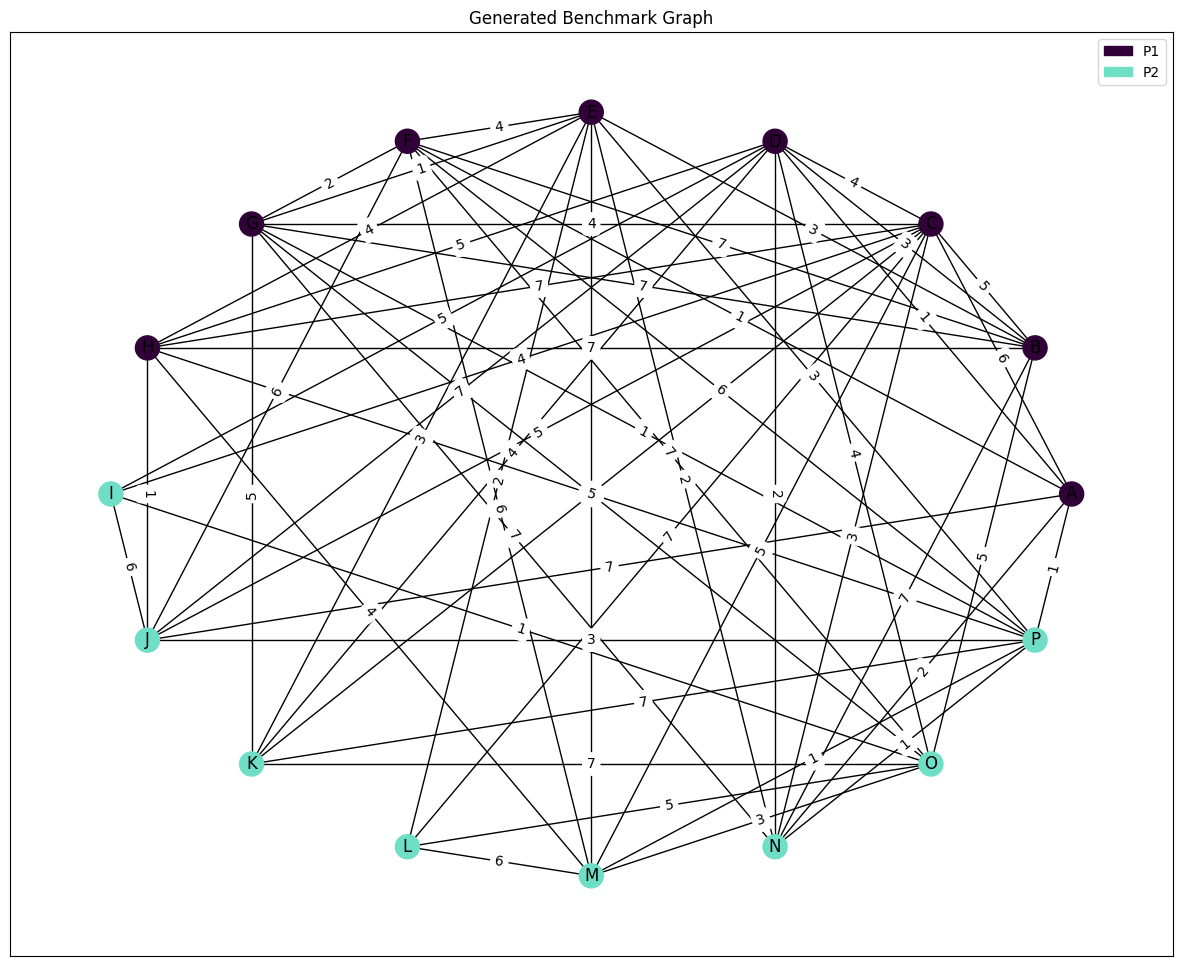

In [6]:
g = generate_benchmark(16, seed = 69)

graph = convert_to_our_graph(g, init_partition_generator(8,8))
v.addEdges(graph)
v.visualize("Generated Benchmark Graph")

In [7]:
swaps,m = kerninghan_lin(graph)

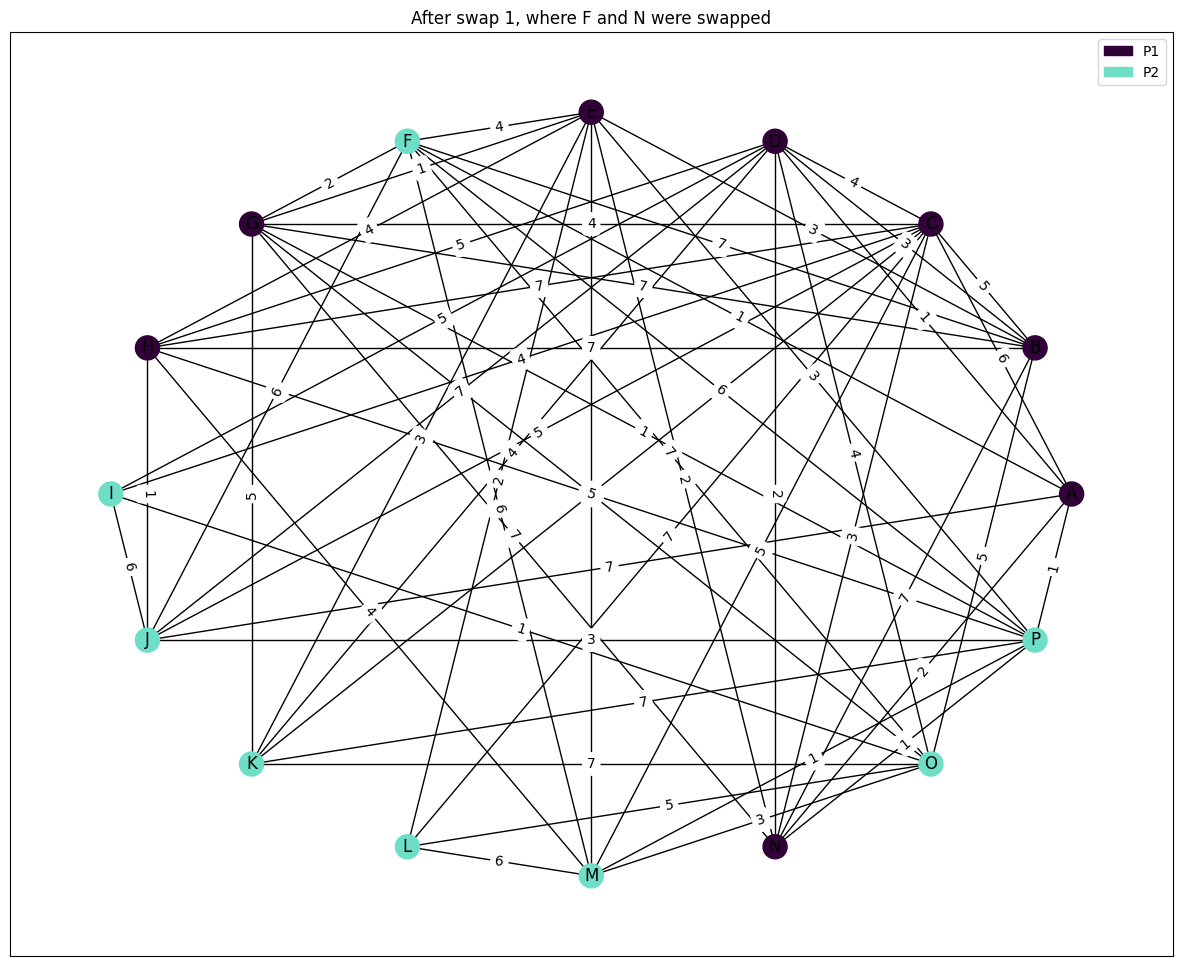

The new cut size (partitioning cost) is 101


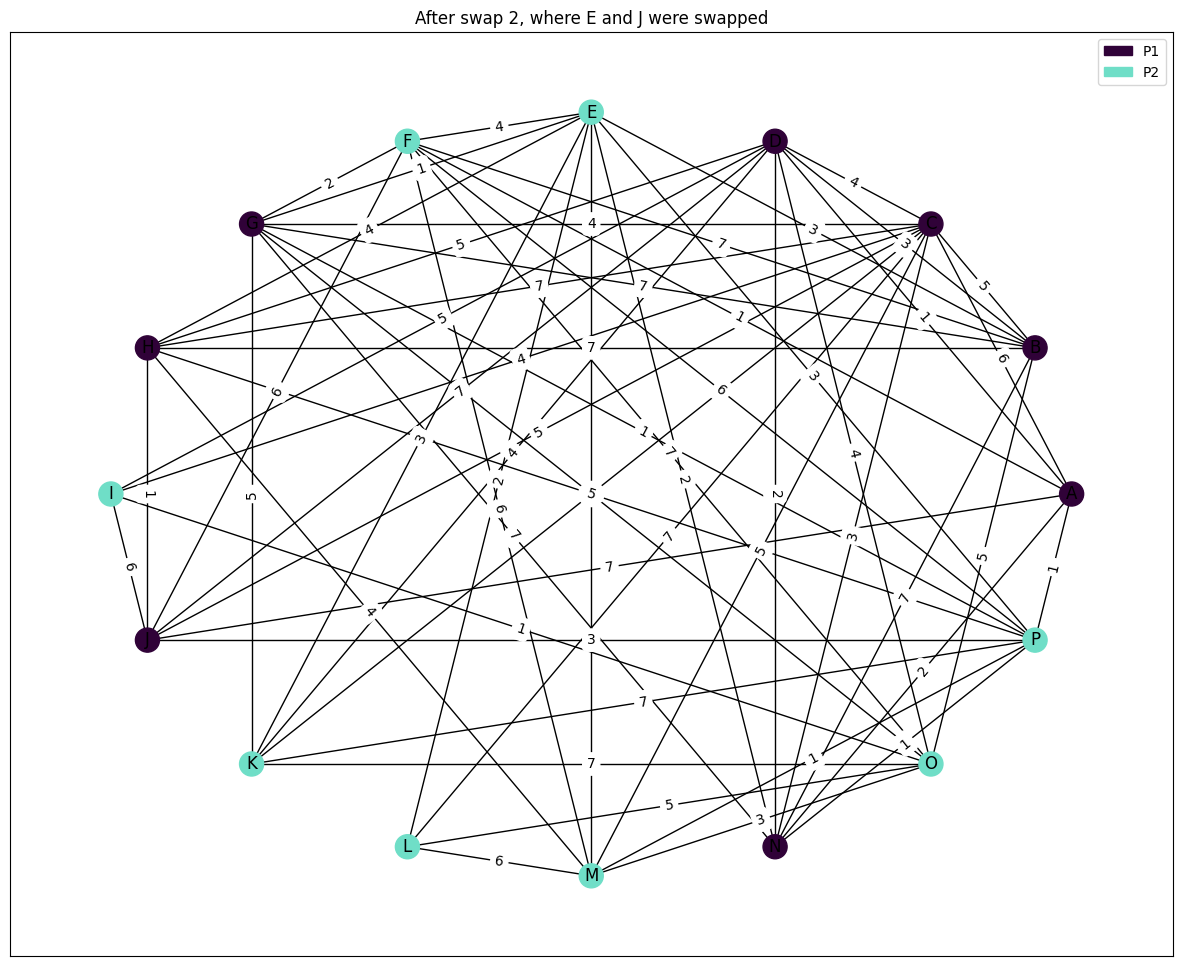

The new cut size (partitioning cost) is 92


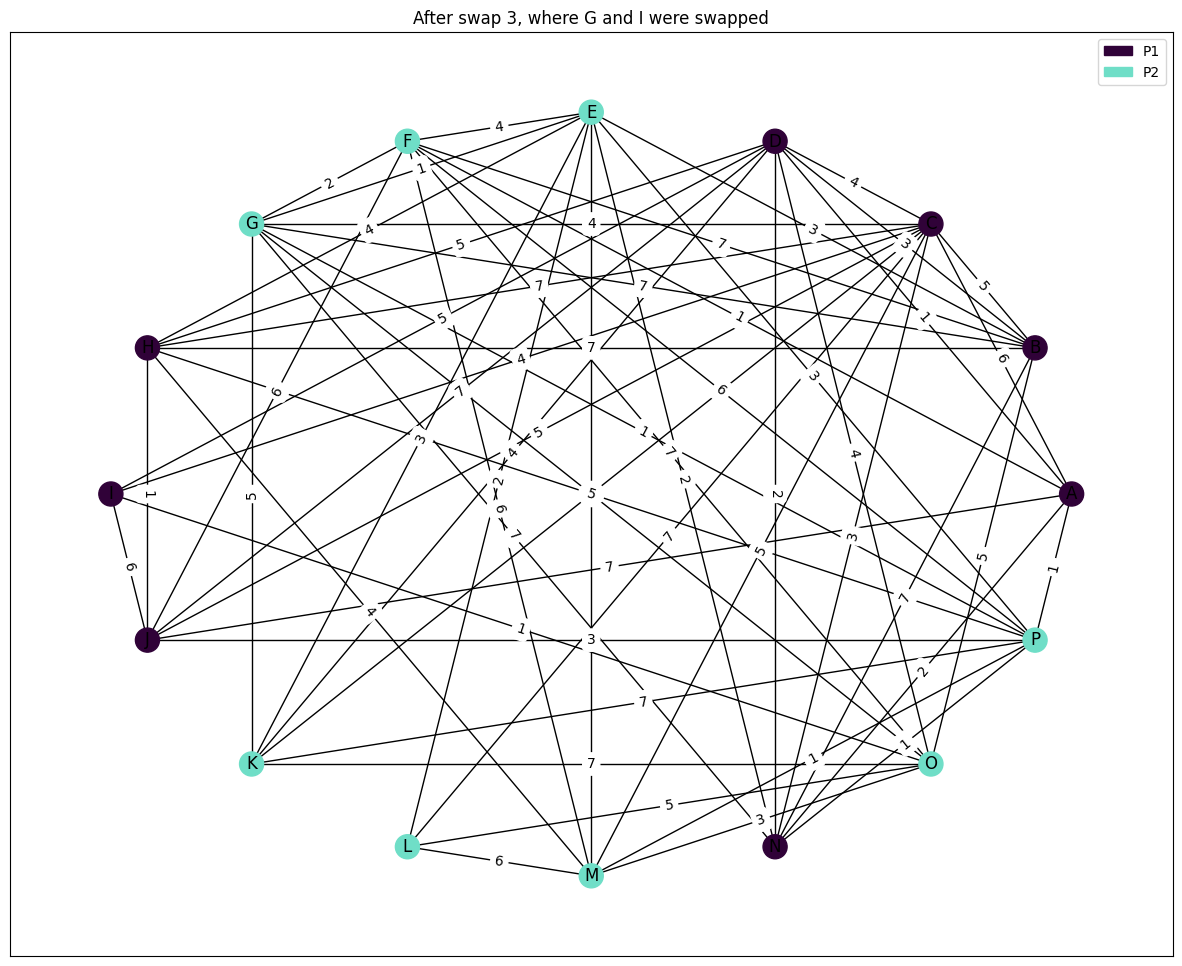

The new cut size (partitioning cost) is 85


In [8]:
k = 0
while(k <= m):
    p = swaps[k]
    graph.node_affiliation[p[0]], graph.node_affiliation[p[1]] = graph.node_affiliation[p[1]], graph.node_affiliation[p[0]]
    v.reset()
    v.addEdges(graph)
    v.visualize(f"After swap {k+1}, where {p[0]} and {p[1]} were swapped")
    print("The new cut size (partitioning cost) is",graph.get_cost())
    k += 1

### KL partitioning visualized for partitioning into two non equal partitions

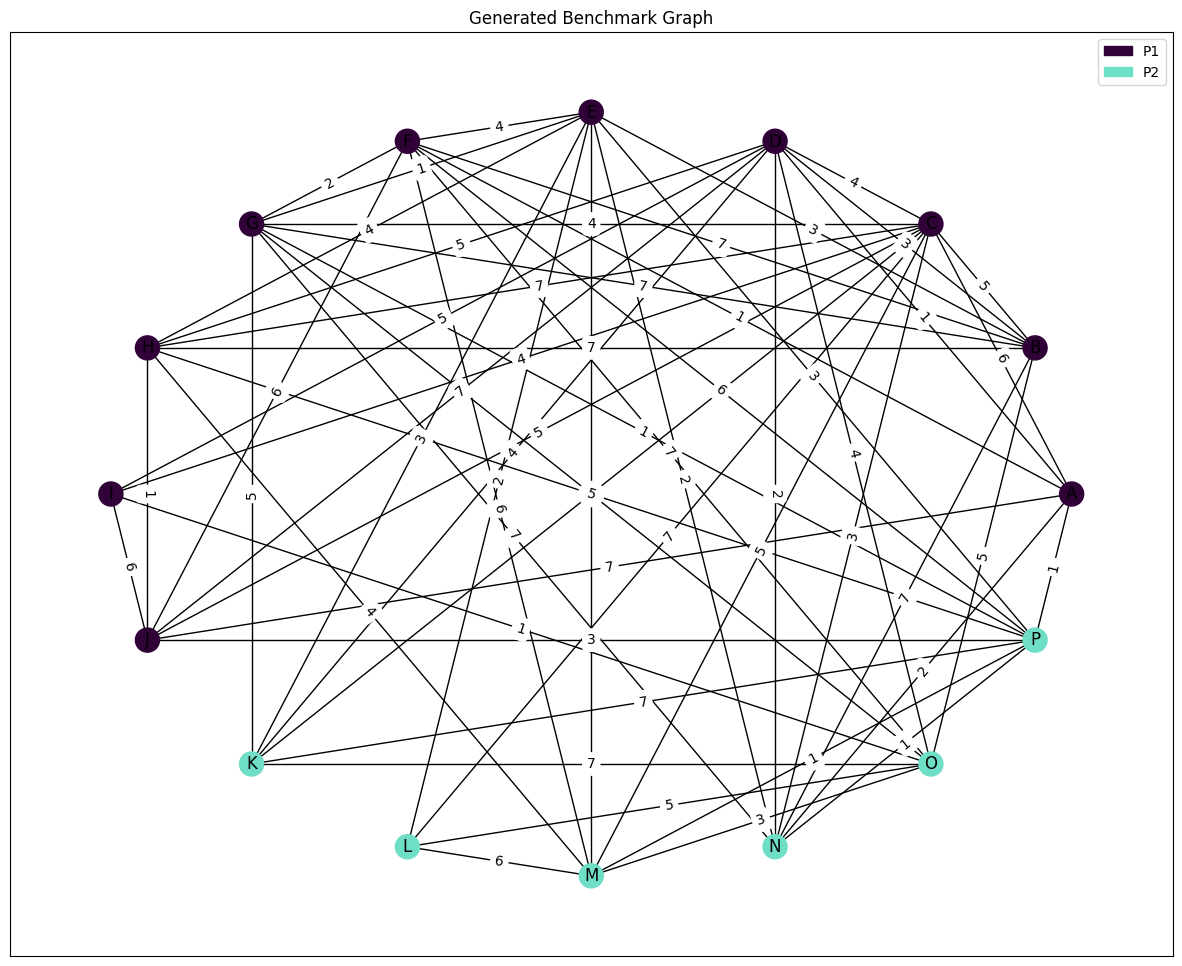

In [9]:
graph = convert_to_our_graph(g, init_partition_generator(10,6))
v.addEdges(graph)
v.visualize("Generated Benchmark Graph")

In [10]:
swaps, m, addednodes = kerninghan_lin_generic(graph)

['a', 'b', 'c', 'd'] were the nodes added


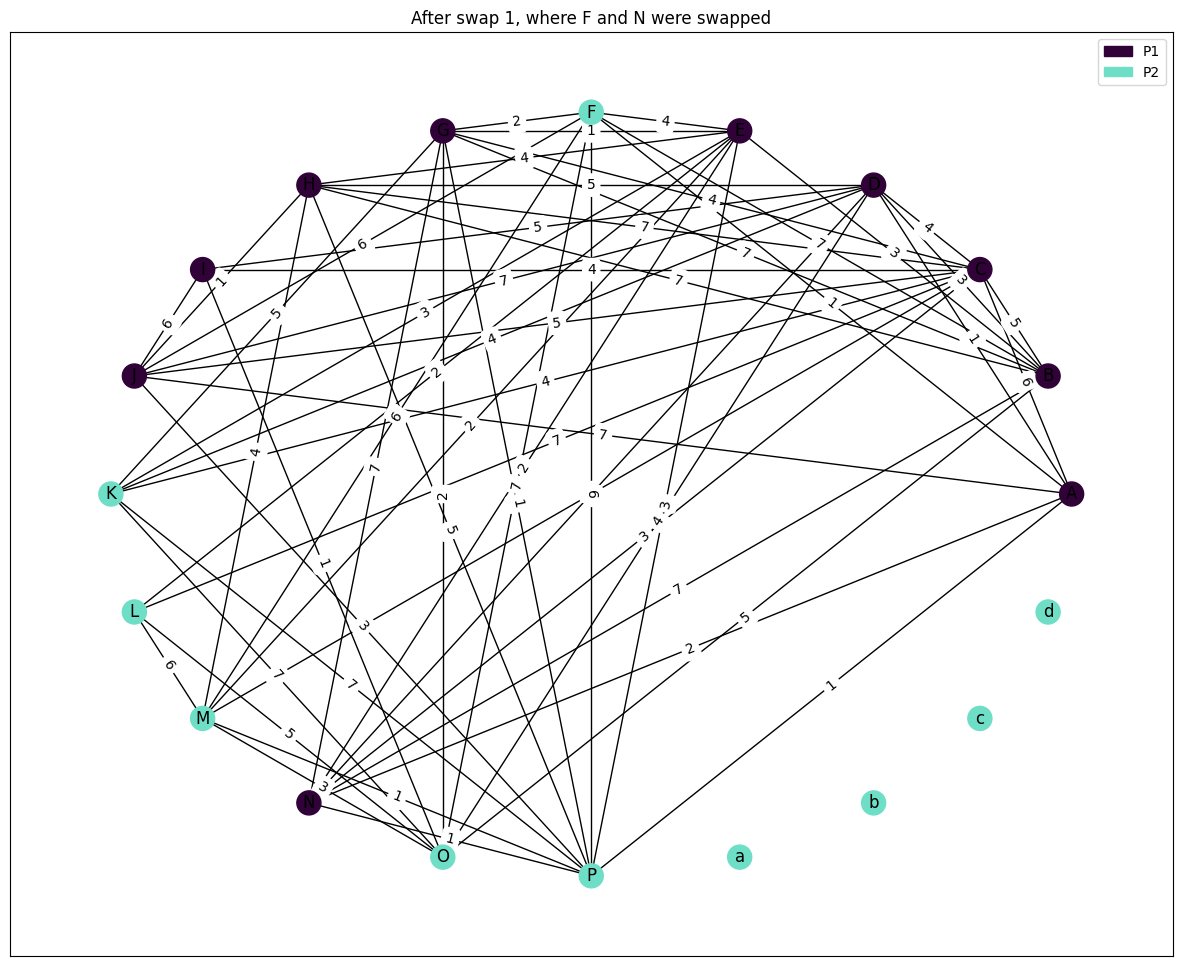

The new cut size (partitioning cost) is 82


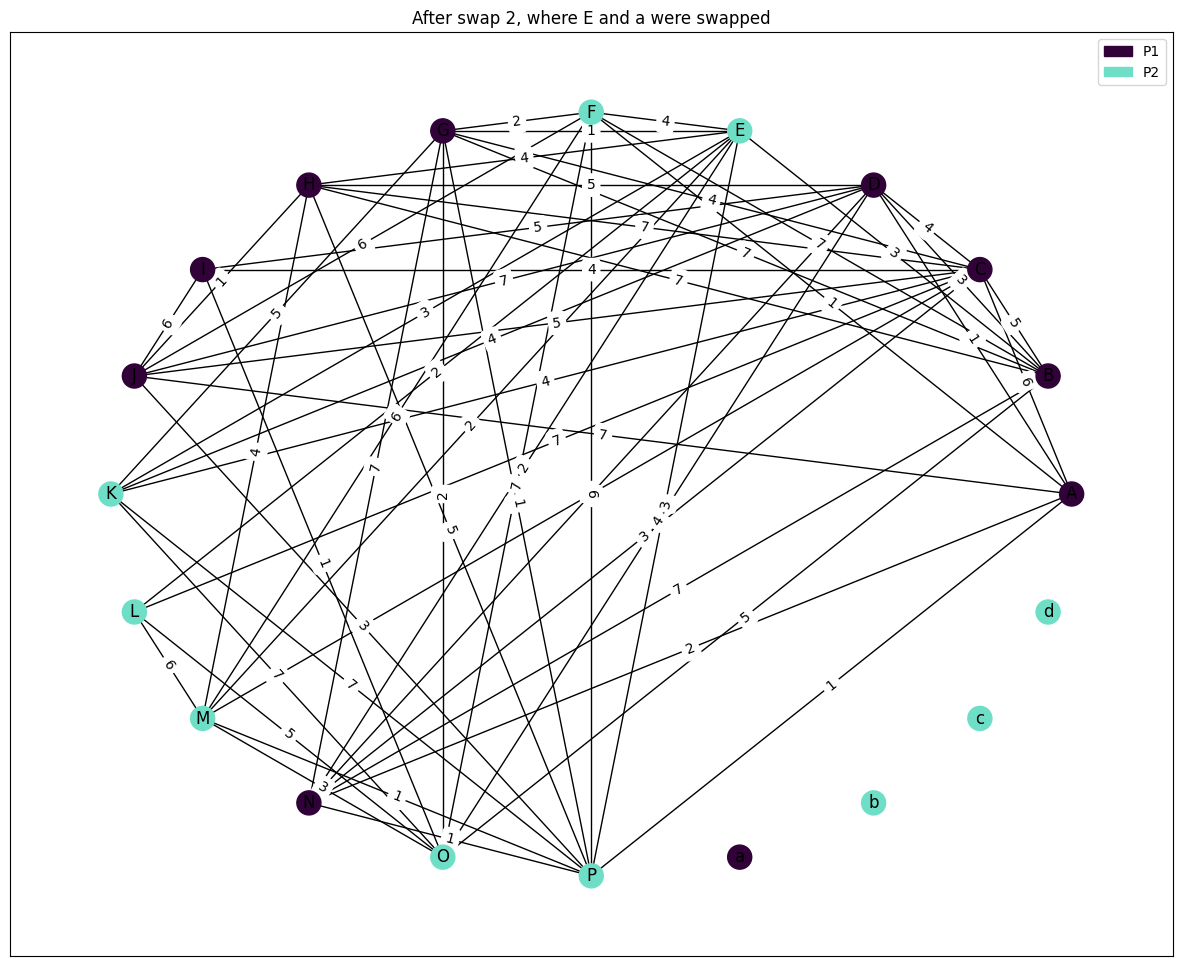

The new cut size (partitioning cost) is 78


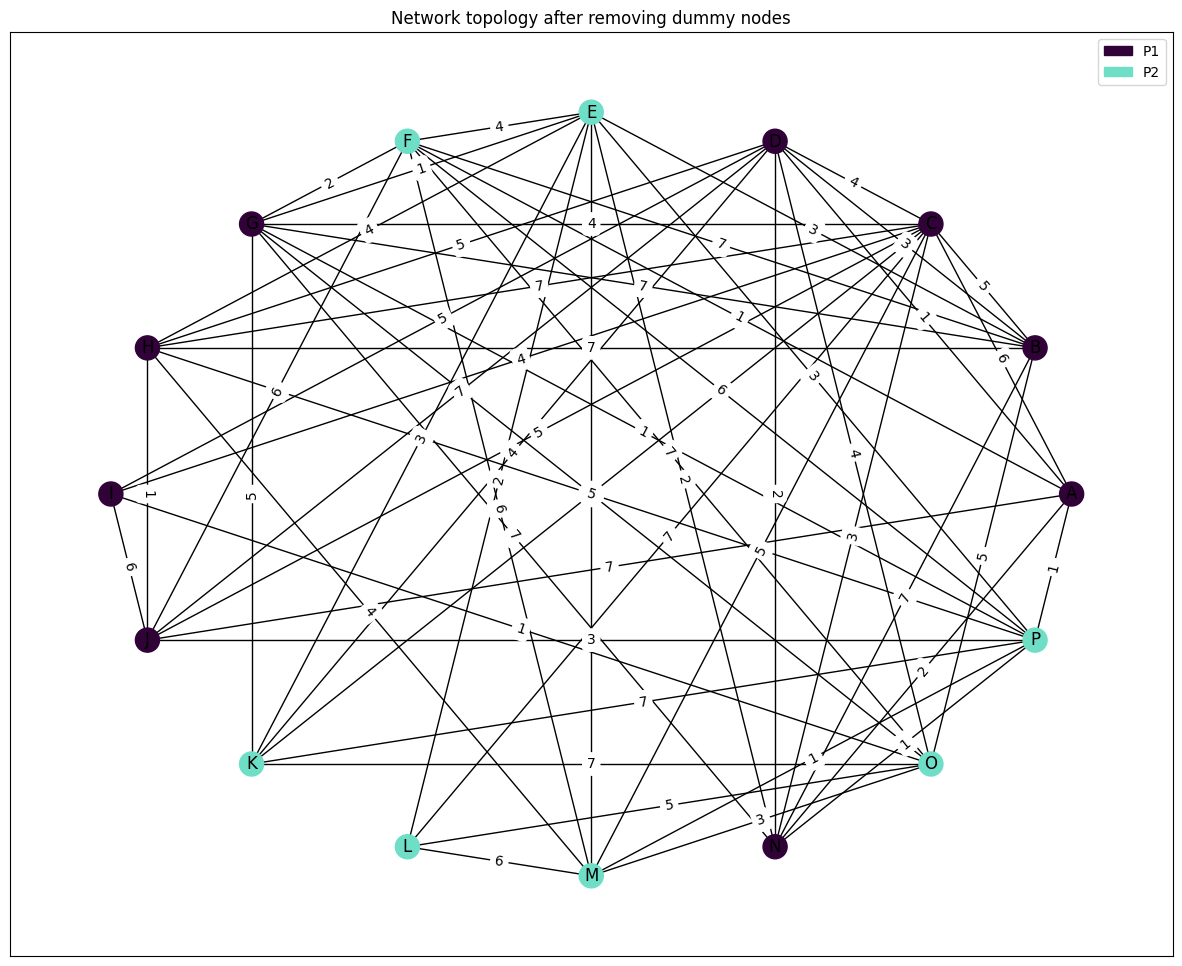

In [11]:
k = 0
while(k <= m):
    p = swaps[k]
    graph.node_affiliation[p[0]], graph.node_affiliation[p[1]] = graph.node_affiliation[p[1]], graph.node_affiliation[p[0]]
    v.reset()
    v.addEdges(graph)
    v.visualize(f"After swap {k+1}, where {p[0]} and {p[1]} were swapped")
    print("The new cut size (partitioning cost) is",graph.get_cost())
    k += 1

for x in addednodes:
    graph.delNode(x)

v.reset()
v.addEdges(graph)
v.visualize(f"Network topology after removing dummy nodes")

### To find the tabulate most optimized partition for all of the possible configurations of partition sizes

In [14]:
def kerninghan_lin_overall(g):
    partitions = {"Initial P1":[], "Initial P2":[], "Final P1":[], "Final P2":[], "length(Pi)":[], "length(Pf)":[], "Cutsize" : [], "Ratio Cut" : []}
    num_nodes = len(g.nodes())
    for i in range(1,num_nodes):
        graph = convert_to_our_graph(g, init_partition_generator(i,num_nodes-i))

        ip1 = [k for k in graph.nodes if graph.node_affiliation[k] == 'P1']
        ip2 = [k for k in graph.nodes if k not in ip1]

        swaps, m, addednodes = kerninghan_lin_generic(graph)
        k = 0
        while(k <= m):
            p = swaps[k]
            graph.node_affiliation[p[0]], graph.node_affiliation[p[1]] = graph.node_affiliation[p[1]], graph.node_affiliation[p[0]]
            k += 1

        for x in addednodes:
            graph.delNode(x)

        p1 = [k for k in graph.nodes if graph.node_affiliation[k] == 'P1']
        p2 = [k for k in graph.nodes if k not in p1]   

        partitions['Initial P1'].append(ip1)
        partitions['Initial P2'].append(ip2)
        partitions["Cutsize"].append(graph.get_cost())
        partitions["Ratio Cut"].append(graph.get_cost()/(i*(num_nodes-i)))
        partitions["Final P1"].append(p1)
        partitions["Final P2"].append(p2)
        partitions["length(Pi)"].append([len(ip1), len(ip2)])
        partitions["length(Pf)"].append([len(p1), len(p2)])
    
    return partitions         

In [15]:
import pandas as pd
g = generate_benchmark(16, seed = 69)
result = pd.DataFrame(kerninghan_lin_overall(g))

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n'] were the nodes added
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l'] were the nodes added
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j'] were the nodes added
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'] were the nodes added
['a', 'b', 'c', 'd', 'e', 'f'] were the nodes added
['a', 'b', 'c', 'd'] were the nodes added
['a', 'b'] were the nodes added
[] were the nodes added
['a', 'b'] were the nodes added
['a', 'b', 'c', 'd'] were the nodes added
['a', 'b', 'c', 'd', 'e', 'f'] were the nodes added
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'] were the nodes added
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j'] were the nodes added
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l'] were the nodes added
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n'] were the nodes added


In [16]:
display(result)

,Initial P1,Initial P2,Final P1,Final P2,length(Pi),length(Pf),Cutsize,Ratio Cut
0,[A],"[B, C, D, E, F, G, H, I, J, K, L, M, N, O, P]",[I],"[A, B, C, D, E, F, G, H, J, K, L, M, N, O, P]","[1, 15]","[1, 15]",16,1.066667
1,"[A, B]","[C, D, E, F, G, H, I, J, K, L, M, N, O, P]","[A, I]","[B, C, D, E, F, G, H, J, K, L, M, N, O, P]","[2, 14]","[2, 14]",34,1.214286
2,"[A, B, C]","[D, E, F, G, H, I, J, K, L, M, N, O, P]","[E, L, M]","[A, B, C, D, F, G, H, I, J, K, N, O, P]","[3, 13]","[3, 13]",51,1.307692
3,"[A, B, C, D]","[E, F, G, H, I, J, K, L, M, N, O, P]","[A, D, I, J]","[B, C, E, F, G, H, K, L, M, N, O, P]","[4, 12]","[4, 12]",52,1.083333
4,"[A, B, C, D, E]","[F, G, H, I, J, K, L, M, N, O, P]","[B, E, F, G, H, K, L, M, N, O, P]","[A, C, D, I, J]","[5, 11]","[11, 5]",68,1.236364
5,"[A, B, C, D, E, F]","[G, H, I, J, K, L, M, N, O, P]","[A, D, I, J, K, P]","[B, C, E, F, G, H, L, M, N, O]","[6, 10]","[6, 10]",80,1.333333
6,"[A, B, C, D, E, F, G]","[H, I, J, K, L, M, N, O, P]","[B, E, F, G, K, N, O, P]","[A, C, D, H, I, J, L, M]","[7, 9]","[8, 8]",78,1.238095
7,"[A, B, C, D, E, F, G, H]","[I, J, K, L, M, N, O, P]","[A, B, C, D, H, I, J, N]","[E, F, G, K, L, M, O, P]","[8, 8]","[8, 8]",85,1.328125
8,"[A, B, C, D, E, F, G, H, I]","[J, K, L, M, N, O, P]","[A, B, C, D, G, H, I, J, N]","[E, F, K, L, M, O, P]","[9, 7]","[9, 7]",78,1.238095
9,"[A, B, C, D, E, F, G, H, I, J]","[K, L, M, N, O, P]","[A, B, C, D, G, H, I, J, N]","[E, F, K, L, M, O, P]","[10, 6]","[9, 7]",78,1.300000
